In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
print('Size of train dataset: {} ____ Size of test dataset: {}'.format(train.shape,test.shape))
train.head()

Size of train dataset: (11504798, 12) ____ Size of test dataset: (7669866, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


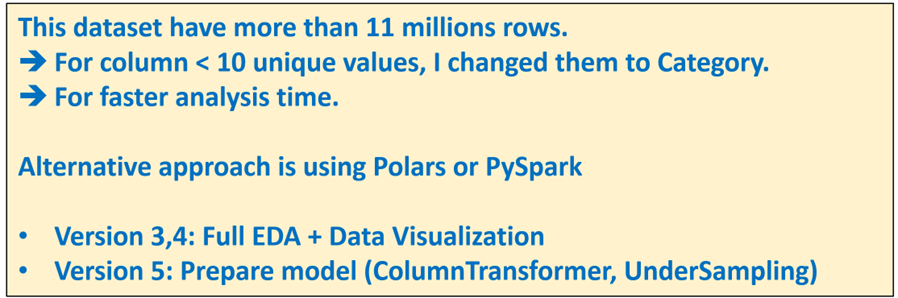

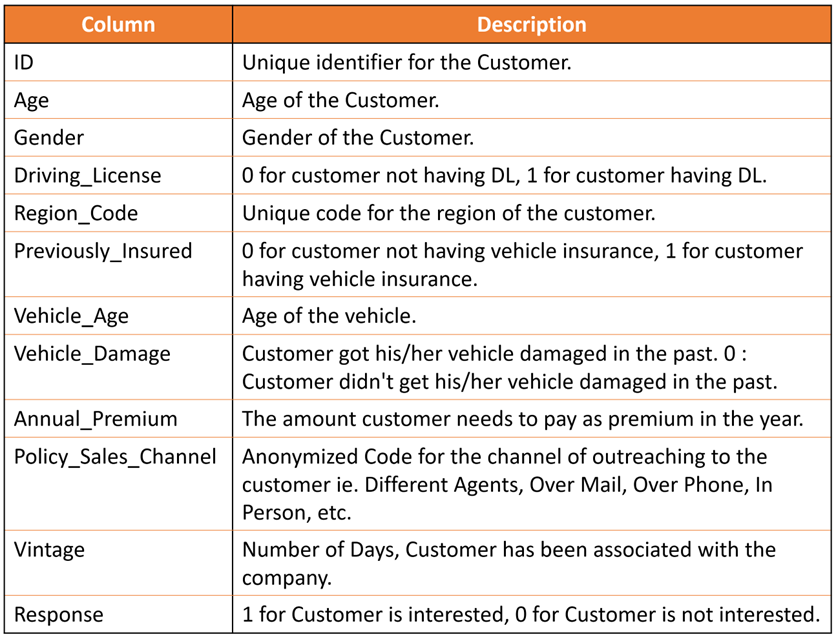

# Summary about the dataset:

In [3]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11504798.0,5.752398e+06,3.321149e+06,0.0,2876199.25,5752398.5,8628597.75,11504797.0
Age,11504798.0,3.838356e+01,1.499346e+01,20.0,24.00,36.0,49.00,85.0
Driving_License,11504798.0,9.980220e-01,4.443120e-02,0.0,1.00,1.0,1.00,1.0
Region_Code,11504798.0,2.641869e+01,1.299159e+01,0.0,15.00,28.0,35.00,52.0
Previously_Insured,11504798.0,4.629966e-01,4.986289e-01,0.0,0.00,0.0,1.00,1.0
Annual_Premium,11504798.0,3.046137e+04,1.645475e+04,2630.0,25277.00,31824.0,39451.00,540165.0
Policy_Sales_Channel,11504798.0,1.124254e+02,5.403571e+01,1.0,29.00,151.0,152.00,163.0
Vintage,11504798.0,1.638977e+02,7.997953e+01,10.0,99.00,166.0,232.00,299.0
Response,11504798.0,1.229973e-01,3.284341e-01,0.0,0.00,0.0,0.00,1.0


In [4]:
# Define column
less = []
for i in train.columns[1:]:
    if train[i].nunique() < 10:
        less.append(i)
        
print('Column have LESS than 10 unique values: ', less)
print('Column have MORE than 10 unique values: ', [i for i in train.columns if i not in less])

Column have LESS than 10 unique values:  ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']
Column have MORE than 10 unique values:  ['id', 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']


In [5]:
# Change to categorical columns for faster analysis:
for i in less:
    train[i] = train[i].astype('category')
    
from pandas.api.types import CategoricalDtype

# Define the new order of categories
new_categories = ['< 1 Year', '1-2 Year', '> 2 Years']

# Create a new CategoricalDtype with the desired order
new_dtype = CategoricalDtype(categories=new_categories, ordered=True)

# Update the 'Vehicle_Age' column with the new dtype
train['Vehicle_Age'] = train['Vehicle_Age'].astype(new_dtype)

# Data Visualization:

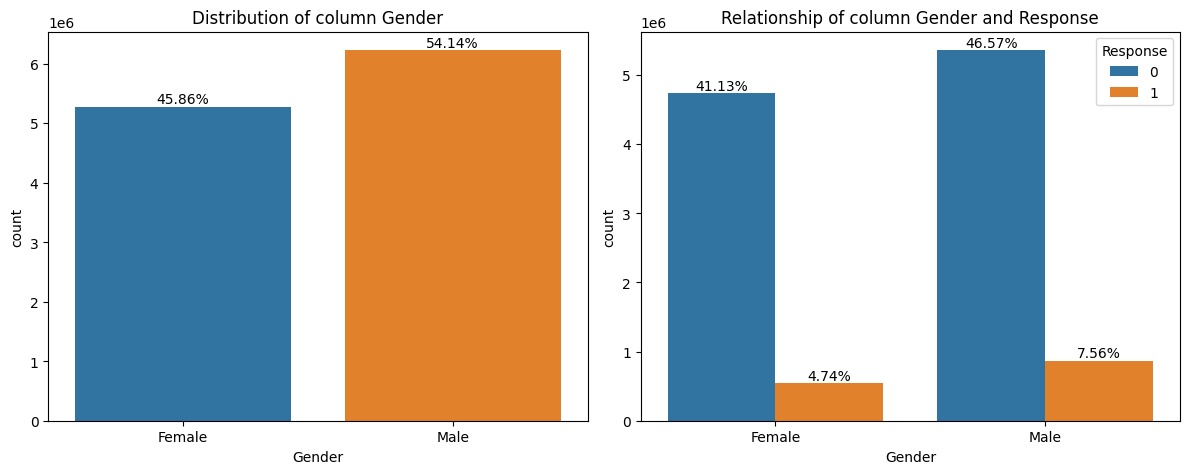

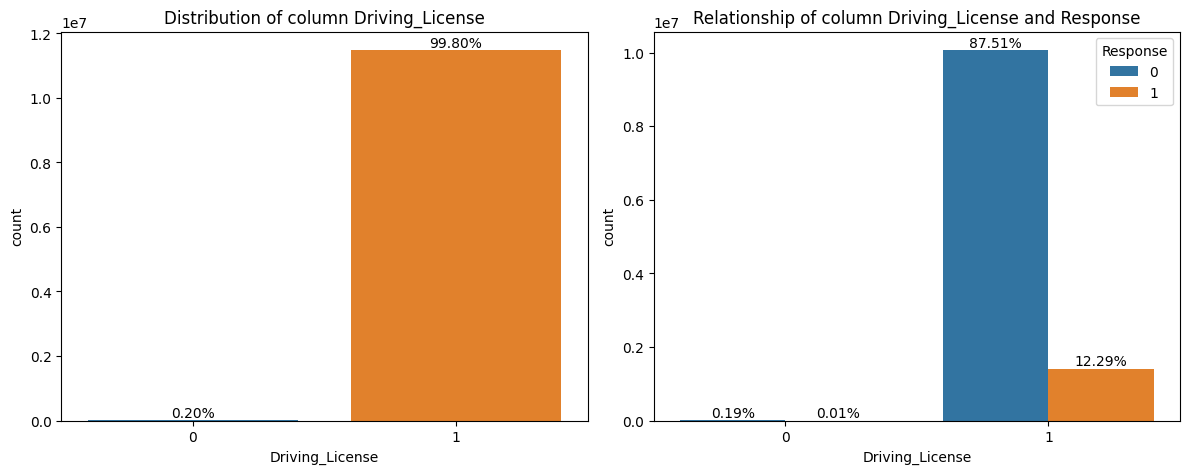

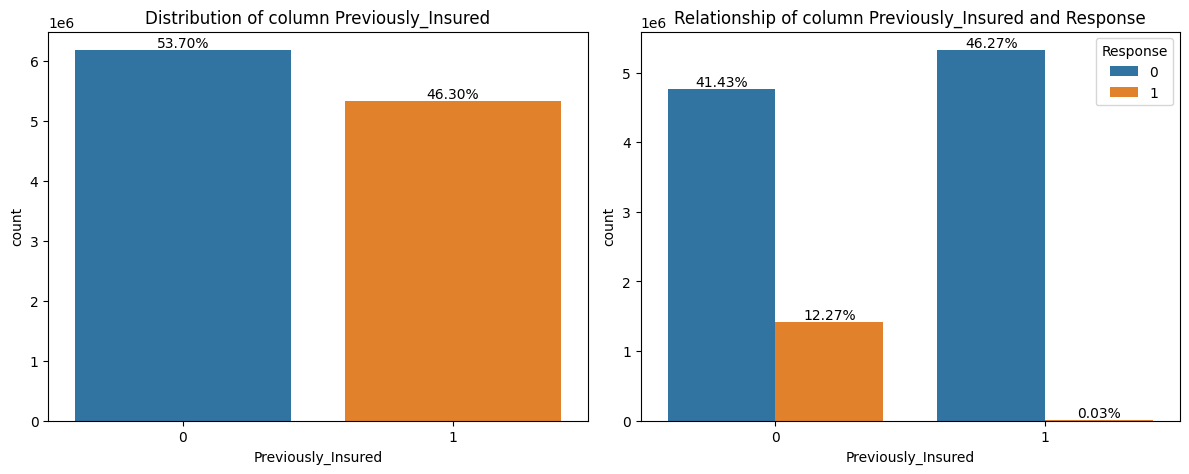

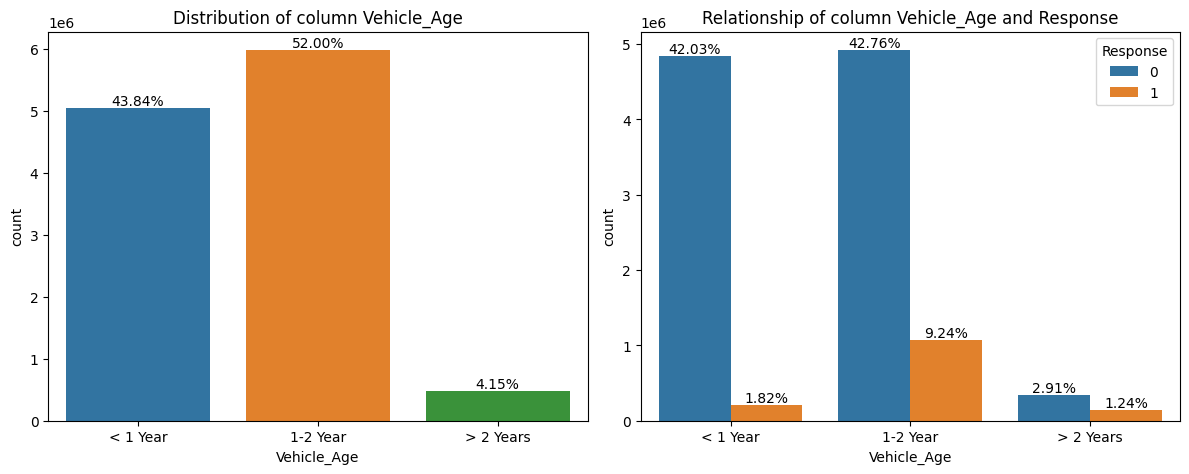

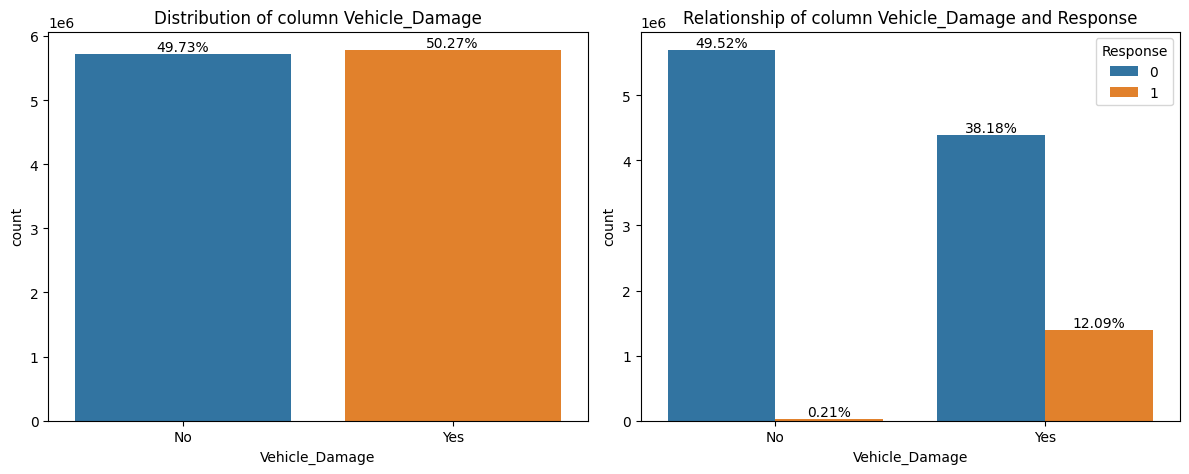

In [6]:
for i in less[:-1]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plotting the first countplot
    sns.countplot(x=i, data=train, ax=ax[0])
    ax[0].set_title(f'Distribution of column {i}')
    
    # Adding percentages on top of the bars for the first countplot
    total = len(train)
    for p in ax[0].patches:
        percentage = f'{100 * p.get_height() / total:.2f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 30 
        ax[0].annotate(percentage, (x, y), ha='center', va='bottom')

    # Plotting the second countplot with hue='Response'
    sns.countplot(x=i, data=train, hue='Response', ax=ax[1])
    ax[1].set_title(f'Relationship of column {i} and Response')
    
    # Adding percentages on top of the bars for the second countplot
    for p in ax[1].patches:
        height = p.get_height()
        total = sum([p.get_height() for p in ax[1].patches if p.get_x() == p.get_x()])  # Total height for this x value
        percentage = f'{100 * height / total:.2f}%' if total > 0 else '0%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 30
        ax[1].annotate(percentage, (x, y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

* Driver License: Although most people have a driver's license, the majority are not interested in responding.
* Previously Insured: The distribution is equal between having or not having vehicle insurance before. Although they don't have vehicle insurance, only 13% of people are interested in responding.
* Vehicle Age: Most of them are not interested in responding.
* Vehicle Damage: The distribution of vehicle damage is similar to that of previously insured.

# Correlation 

<Axes: >

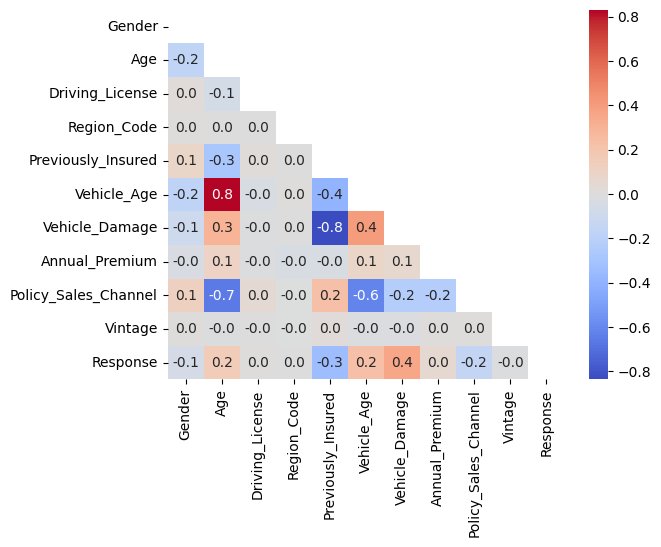

In [7]:
new = train.copy().drop('id',axis=1)
new['Gender'] = new['Gender'].map({'Male':0,'Female':1})
new['Vehicle_Age'] = new['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1,'> 2 Years':2})
new['Vehicle_Damage'] = new['Vehicle_Damage'].map({'Yes':1,'No':0})

sns.heatmap(new.corr(method='spearman'),
           mask = np.triu(np.ones_like(new.corr(method='spearman'),dtype=bool)),
           annot=True,cmap='coolwarm',fmt='.1f')

* Vehicle_Age  -----------	Age	0.830604
* Policy_Sales_Channel -----------	Vehicle_Age	-0.619321
* Policy_Sales_Channel -----------	Age	-0.656080
* Vehicle_Damage -----------	Previously_Insured	-0.836214

In [8]:
high_pairs = new.corr(method='spearman').where(np.tril(np.ones(new.corr(method='spearman').shape), k=-1).astype(bool))
high_pairs = high_pairs.stack().reset_index()
high_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_pairs = high_pairs[(high_pairs['Correlation'] >= 0.5) | (high_pairs['Correlation'] <= -0.5)]

high = high_pairs.sort_values('Correlation',ascending=False)
high

,Feature 1,Feature 2,Correlation
11,Vehicle_Age,Age,0.830604
33,Policy_Sales_Channel,Vehicle_Age,-0.619321
29,Policy_Sales_Channel,Age,-0.656080
19,Vehicle_Damage,Previously_Insured,-0.836214


# Mutual Infomation:

In [9]:
# X = new.drop('Response',axis=1)
# y = new['Response']

# from sklearn.feature_selection import mutual_info_classif

# def make_mi_scores(X, y):
#     mi_scores = mutual_info_classif(X, y)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# mi_scores = make_mi_scores(X, y)
# mi_scores

# def plot_mi_scores(scores):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")


# plt.figure(dpi=100, figsize=(15, 8))
# plot_mi_scores(mi_scores)

* Policy_Sales_Channel    0.103789
* Region_Code             0.102897
* Age                     0.081696
* Annual_Premium          0.039578
* Vintage                 0.022151

# Relationship between columns

## Driving License vs Vehicle Damage

In [10]:
new.groupby('Driving_License')['Vehicle_Damage'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Driving_License Vehicle_Damage            
0               1                    67.75
                0                    32.25
1               1                    50.23
                0                    49.77

When they don't have a driving license, they tend to damage the vehicle. However, even if they have a driving license, the chance of vehicle damage is still 50:50.

In [11]:
new.groupby(['Driving_License','Vehicle_Damage'])['Response'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Driving_License Vehicle_Damage Response            
0               0              0              99.85
                               1               0.15
                1              0              91.93
                               1               8.07
1               0              0              99.58
                               1               0.42
                1              0              75.90
                               1              24.10

In [12]:
new.dtypes

Gender                  category
Age                        int64
Driving_License         category
Region_Code              float64
Previously_Insured      category
Vehicle_Age             category
Vehicle_Damage          category
Annual_Premium           float64
Policy_Sales_Channel     float64
Vintage                    int64
Response                category
dtype: object

In [13]:
# new['Driving_License_x_Vehicle_Damage'] = 0
# new.loc[(new['Driving_License'] == 0) & (new['Vehicle_Damage'] == 1) & (new['Response'] == 1), 'Driving_License_x_Vehicle_Damage'] = 8
# new.loc[(new['Driving_License'] == 1) & (new['Vehicle_Damage'] == 1) & (new['Response'] == 1), 'Driving_License_x_Vehicle_Damage'] = 24

When the vehicle is damaged, there is a noticeable increase in interest. For people without a driving license, interest rises from 0.15% to 8%, which is an 8-fold increase. For people with a driving license, interest increases from 0.42% to 24%, which is a 24-fold increase.

## Driving_License vs Previously_Insured

In [14]:
new.groupby('Driving_License')['Previously_Insured'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Driving_License Previously_Insured            
0               0                        69.08
                1                        30.92
1               0                        53.67
                1                        46.33

In [15]:
new.groupby(['Driving_License','Previously_Insured'])['Response'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Driving_License Previously_Insured Response            
0               0                  0              92.05
                                   1               7.95
                1                  0              99.93
                                   1               0.07
1               0                  0              77.11
                                   1              22.89
                1                  0              99.94
                                   1               0.06

In [16]:
# new['Driving_License_x_Previously_Insured'] = 0
# new.loc[(new['Driving_License'] == 0) & (new['Previously_Insured'] == 0) & (new['Response'] == 1), 'Driving_License_x_Previously_Insured'] = 8
# new.loc[(new['Driving_License'] == 1) & (new['Previously_Insured'] == 0) & (new['Response'] == 1), 'Driving_License_x_Previously_Insured'] = 23

When vehicles are uninsured, the observed interest percentage is significantly higher compared to insured vehicles. Specifically, the interest rate is eight times higher for uninsured vehicles without a driving license and twenty-three times higher for uninsured vehicles with a driving license.

## Age_Bins vs Vehicle_Age Correlation = 0.8

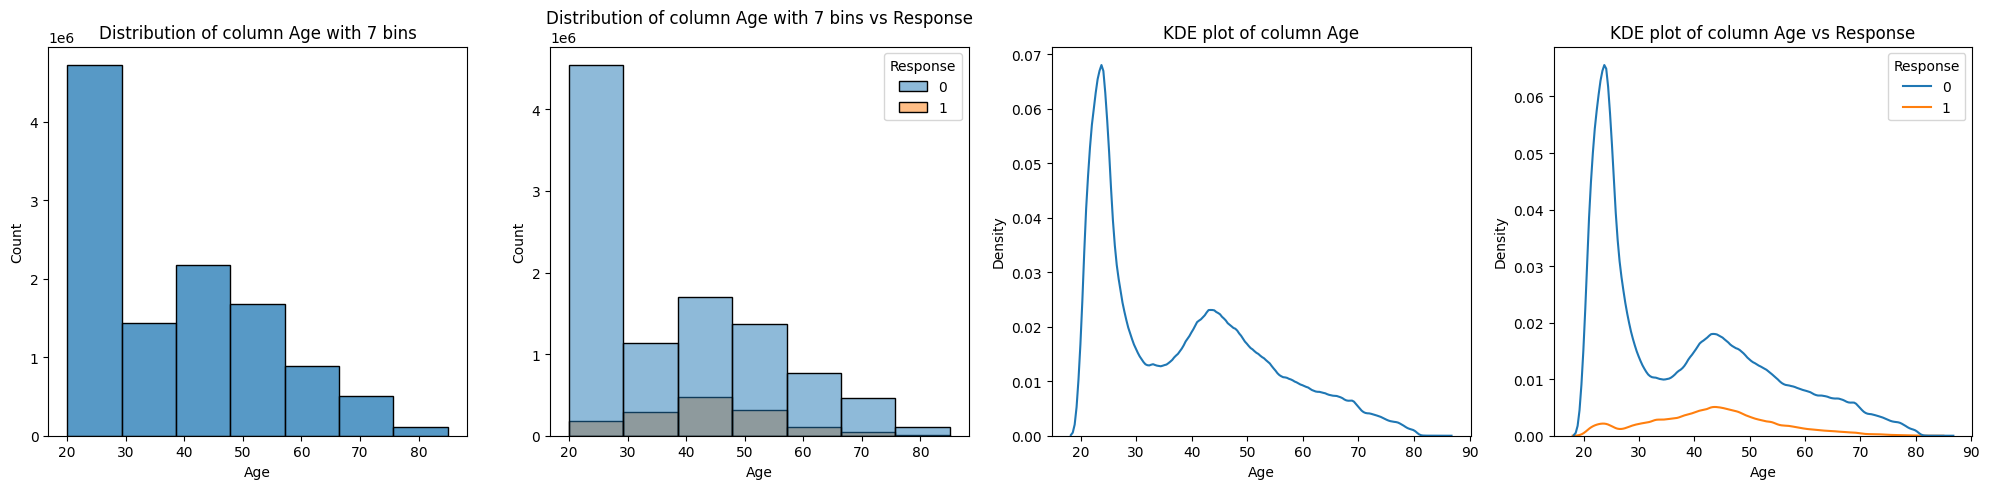

In [17]:
more = [i for i in train.columns if i not in less]
more

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(x='Age', data=train, bins=7, ax=ax[0])
ax[0].set_title('Distribution of column Age with 7 bins')
sns.histplot(x='Age', data=train, bins=7, ax=ax[1], hue='Response')
ax[1].set_title('Distribution of column Age with 7 bins vs Response')
sns.kdeplot(x='Age', data=train, ax=ax[2])
ax[2].set_title('KDE plot of column Age')
sns.kdeplot(x='Age', data=train, ax=ax[3], hue='Response')
ax[3].set_title('KDE plot of column Age vs Response')

plt.tight_layout()
plt.show()

In [18]:
new['age_bins'] = pd.cut(new['Age'], bins=7)
new['Age_Type'] = new['age_bins'].cat.codes
new['age_bins'].value_counts(normalize=True).mul(100).round(2)

age_bins
(19.935, 29.286]    41.03
(38.571, 47.857]    18.92
(47.857, 57.143]    14.63
(29.286, 38.571]    12.44
(57.143, 66.429]     7.67
(66.429, 75.714]     4.36
(75.714, 85.0]       0.95
Name: proportion, dtype: float64

In [19]:
new.groupby('Age_Type')['Vehicle_Age'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Age_Type Vehicle_Age            
0        0                 96.94
         1                  3.04
         2                  0.02
1        1                 67.27
         0                 31.23
         2                  1.50
2        1                 94.15
         2                  5.41
         0                  0.44
3        1                 89.94
         2                  9.59
         0                  0.46
4        1                 87.84
         2                 11.81
         0                  0.35
5        1                 88.08
         2                 11.79
         0                  0.14
6        1                 88.12
         2                 11.84
         0                  0.03

In [20]:
new.groupby(['Age_Type','Vehicle_Age'])['Response'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Age_Type Vehicle_Age Response            
0        0           0              96.83
                     1               3.17
         1           0              77.64
                     1              22.36
         2           0              84.34
                     1              15.66
1        0           0              86.47
                     1              13.53
         1           0              76.85
                     1              23.15
         2           0              71.91
                     1              28.09
2        0           0              85.64
                     1              14.36
         1           0              78.98
                     1              21.02
         2           0              64.00
                     1              36.00
3        0           0              82.14
                     1              17.86
         1           0              82.75
                     1              17.25
         2           0              66.22
                     1              33.78
4        0           0              90.44
                     1               9.56
         1           0              89.07
                     1              10.93
         2           0              74.29
                     1              25.71
5        0           0              91.13
                     1               8.87
         1           0              93.53
                     1               6.47
         2           0              81.15
                     1              18.85
6        0           0              86.49
                     1              13.51
         1           0              96.70
                     1               3.30
         2           0              85.51
                     1              14.49

<Axes: xlabel='Vehicle_Age', ylabel='Age_Type'>

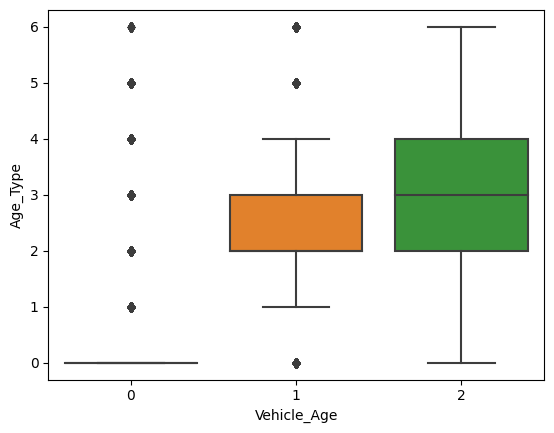

In [21]:
sns.boxplot(x='Vehicle_Age', y='Age_Type', data=new)

<Axes: xlabel='Vehicle_Age', ylabel='Age_Type'>

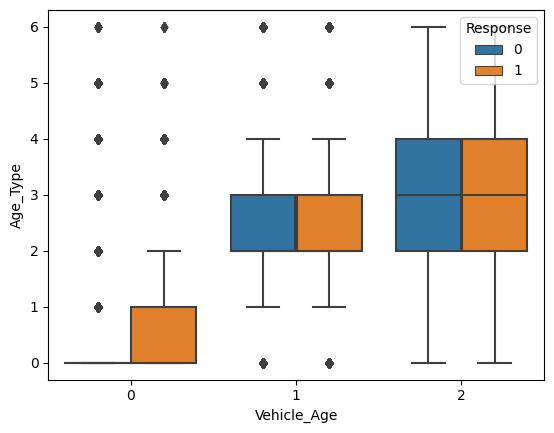

In [22]:
sns.boxplot(x='Vehicle_Age', y='Age_Type',hue='Response',data=new)

<Axes: xlabel='Age_x_Vehicle', ylabel='count'>

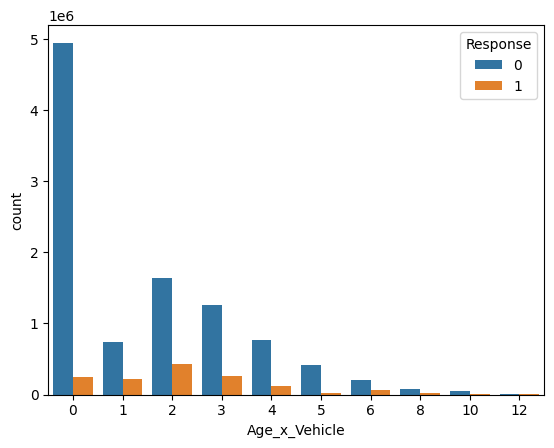

In [23]:
new['Age_x_Vehicle'] = new['Age_Type'] * new['Vehicle_Age'].cat.codes
sns.countplot(x='Age_x_Vehicle',hue='Response',data=new)

* In most age bins, younger vehicle ages (0 years) have higher percentages of response 0.
* As vehicle age increases to 2 years, there tends to be a higher percentage of response 1 in most age bins.
* The youngest age bin (19.935 to 29.286) and the oldest age bin (66.429 to 85.0) show relatively high percentages of response 0 for vehicle age 0.
* There is variability in response percentages as vehicle age increases within each age bin.

# Vehicle Damage vs Previously Insured: Corrlation = -0.8

In [24]:
new.groupby('Vehicle_Damage')['Previously_Insured'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Vehicle_Damage Previously_Insured            
0              1                        88.22
               0                        11.78
1              0                        95.17
               1                         4.83

In [25]:
new.groupby(['Vehicle_Damage','Previously_Insured'])['Response'].value_counts(normalize=True).mul(100).round(2).to_frame()

proportion
Vehicle_Damage Previously_Insured Response            
0              0                  0              96.67
                                  1               3.33
               1                  0              99.97
                                  1               0.03
1              0                  0              74.76
                                  1              25.24
               1                  0              99.35
                                  1               0.65

In [26]:
# new['Vehicle_Damage_x_Previously_Insured'] = 0
# new.loc[(new['Vehicle_Damage'] == 0) & (new['Previously_Insured'] == 0) & (new['Response'] == 1), 'Vehicle_Damage_x_Previously_Insured'] = 3
# new.loc[(new['Vehicle_Damage'] == 1) & (new['Previously_Insured'] == 0) & (new['Response'] == 1), 'Vehicle_Damage_x_Previously_Insured'] = 25

* Only those who got Vehicle Damage and don't have Previously_Insured are interested in Response (25 times)

# Policy Sales Channel vs Age Bins: Correlation   -0.656080

<Axes: xlabel='Age_Type', ylabel='Policy_Sales_Channel'>

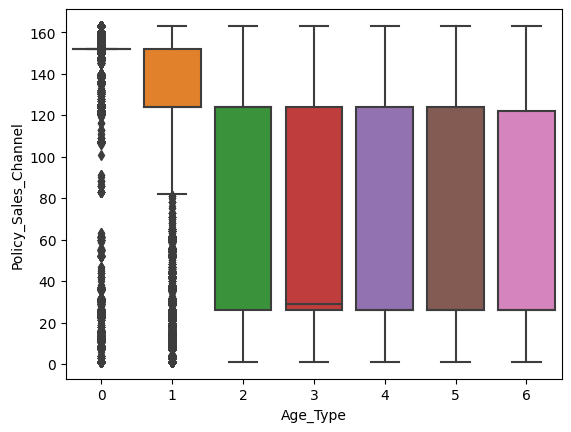

In [27]:
sns.boxplot(x='Age_Type',y='Policy_Sales_Channel',data=new)

<Axes: xlabel='Age_Type', ylabel='Policy_Sales_Channel'>

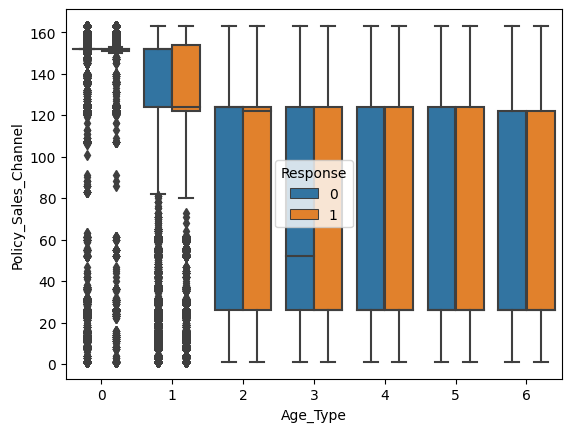

In [28]:
sns.boxplot(y='Policy_Sales_Channel',x='Age_Type',hue='Response',data=new)

# Policy Sales Channel vs Vehicle Age: Correlation   -0.619

<Axes: xlabel='Vehicle_Age', ylabel='Policy_Sales_Channel'>

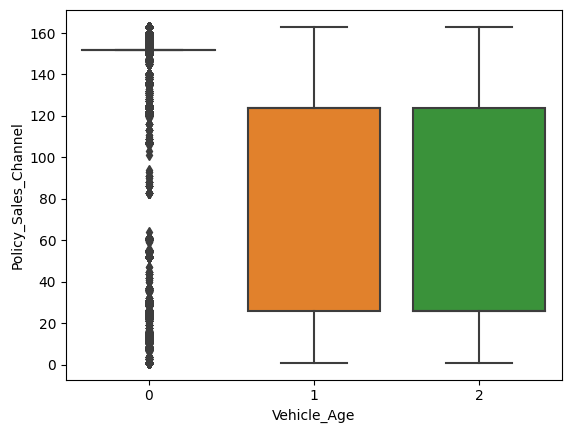

In [29]:
sns.boxplot(x='Vehicle_Age',y='Policy_Sales_Channel',data=new)

<Axes: xlabel='Vehicle_Age', ylabel='Policy_Sales_Channel'>

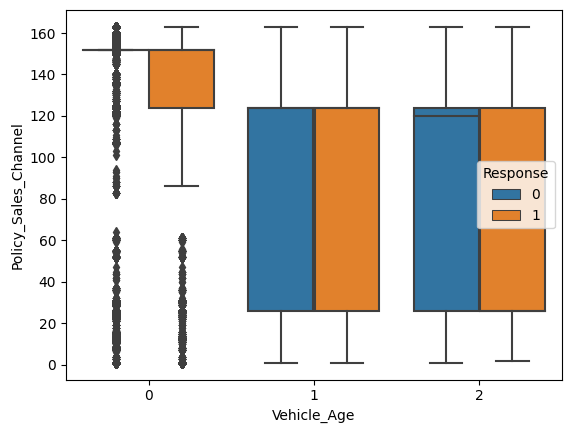

In [30]:
sns.boxplot(x='Vehicle_Age',y='Policy_Sales_Channel',hue='Response',data=new)

# CONCLUSION:
* **Driving License vs Vehicle Damage**: When the vehicle is damaged, there is a noticeable increase in interest. For people without a driving license, interest rises from 0.15% to 8% ***(8 Times)***. For people with a driving license, interest increases from 0.42% to 24%, ***(24 Times)***.

* **Driving License vs Previously Insured**: When vehicles are uninsured, the observed interest percentage is significantly higher compared to insured vehicles. Specifically, the interest rate is eight times higher for uninsured vehicles without a driving license and twenty-three times higher for uninsured vehicles with a driving license.

* **Age_Bins vs Vehicle_Age**: As vehicle age increases to 2 years, there tends to be a higher percentage of response 1 in most age bins.

* **Vehicle Damage vs Previously Insured**: Only those who got Vehicle Damage and don't have Previously_Insured are interested in Response (25 times)

# Number columns

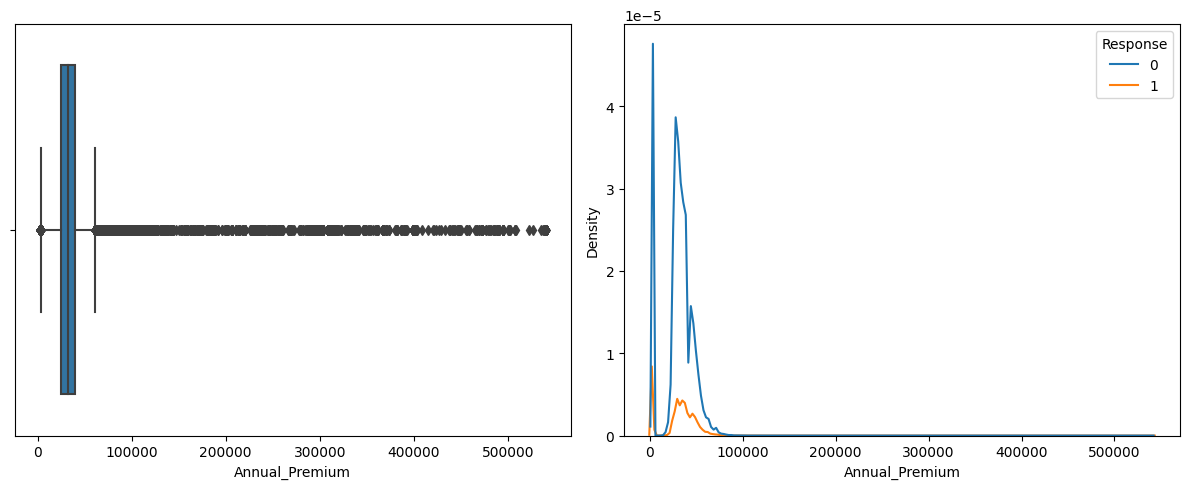

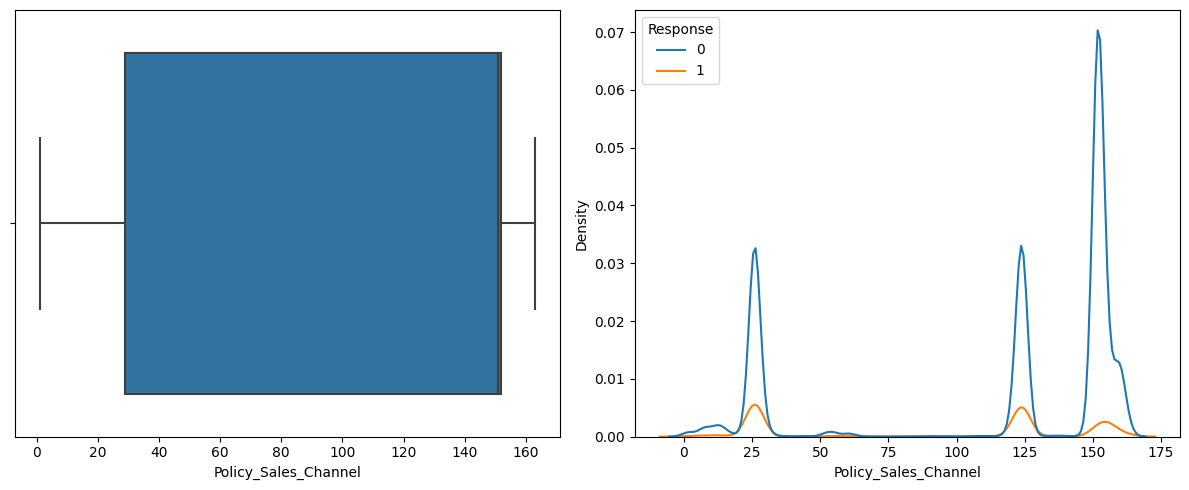

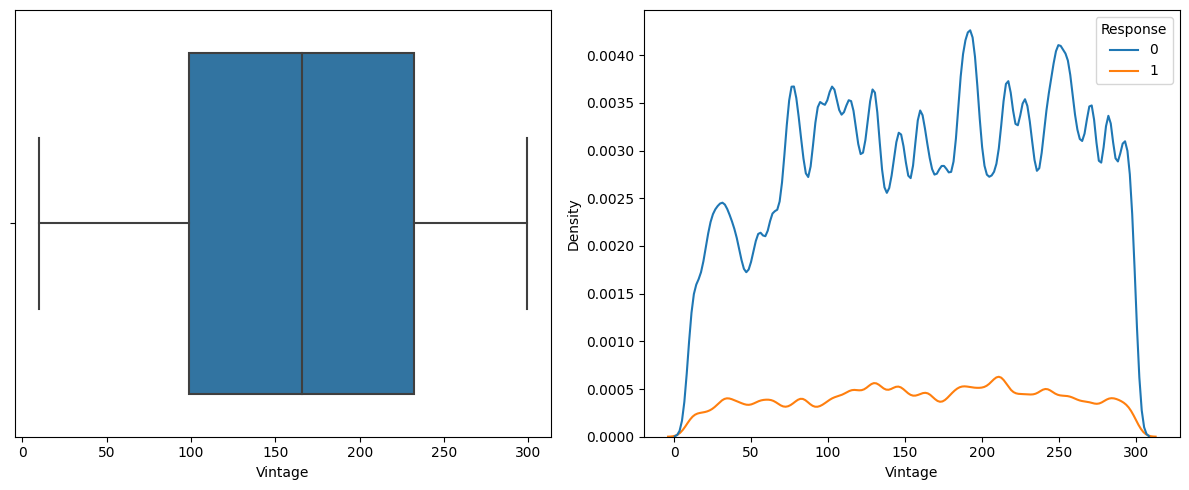

In [31]:
num =  ['Annual_Premium','Policy_Sales_Channel', 'Vintage']

for i in num:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plotting the first countplot
    sns.boxplot(x=i, data=new, ax=ax[0])
#     ax[0].set_title(f'Distribution of column {i}')
    
    # Plotting the second countplot with hue='Response'
    sns.kdeplot(x=i, data=new, hue='Response', ax=ax[1])

    plt.tight_layout()
    plt.show()

# Target Column:

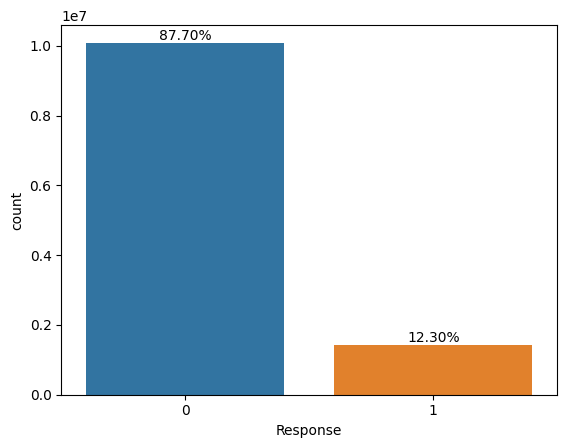

In [32]:
fig, ax = plt.subplots()
sns.countplot(x='Response', data=train, ax=ax)

# Calculate the total number of instances
total = len(train)

# Add percentages on top of the bars
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 5  # Adjust the position above the bar
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Prepare model

In [33]:
train['age_bins'] = pd.cut(train['Age'], bins=7)
train['Age_Type'] = train['age_bins'].cat.codes
train['Age_x_Vehicle_Age'] = train['Age_Type'] * train['Vehicle_Age'].cat.codes
train['Age_x_Vehicle_Damage'] = train['Age_Type'] * train['Vehicle_Damage'].cat.codes
train['Age_x_Previously_Insured'] = train['Age_Type'] * train['Previously_Insured'].cat.codes
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_bins,Age_Type,Age_x_Vehicle_Age,Age_x_Vehicle_Damage,Age_x_Previously_Insured
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0,"(19.935, 29.286]",0,0,0,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1,"(38.571, 47.857]",2,4,2,0
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0,"(19.935, 29.286]",0,0,0,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0,"(29.286, 38.571]",1,1,1,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0,"(29.286, 38.571]",1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0,"(47.857, 57.143]",3,3,3,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1,"(19.935, 29.286]",0,0,0,0
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0,"(19.935, 29.286]",0,0,0,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1,"(47.857, 57.143]",3,3,3,0


* Define X,y
1. OneHotencoder: Gender, Vehicle_Damage
1. MinMaxScaler: Age, Driving_License, Region_Code, Previously_Insured, Policy_Sales_Channel, Vintage
1. OrdinalEnconder: Vehicle_Age
1. RobustScaler: Annual_Premium
1. StandardScaler: Age_Type, Age_x_Vehicle_Age, Age_x_Vehicle_Damage, Age_x_Previously_Insured

1. Train-Test Split: Split your dataset into training and testing sets.
1. Preprocessing with ColumnTransformer: Apply the necessary preprocessing steps (e.g., scaling, encoding) using ColumnTransformer on the training data.
1. Handling Class Imbalance: Apply SMOTE or undersampling on the preprocessed training data to address class imbalance.


SMOTETomek

In [34]:
X = train.drop(['id','Response','age_bins'],axis=1)
y = train['Response']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 512)

coltrans = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Gender', 'Vehicle_Damage']),
        ('minmax', MinMaxScaler(), ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']),
        ('ordinal', OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ['Vehicle_Age']),
        ('robust', RobustScaler(), ['Annual_Premium']),
        ('standard', StandardScaler(), ['Age_Type', 'Age_x_Vehicle_Age', 'Age_x_Vehicle_Damage', 'Age_x_Previously_Insured'])
    ],
    remainder='passthrough'  # Keeps columns not specified in transformers
)

In [36]:
# Column Transformer
X_train_trans = coltrans.fit_transform(X_train)
X_test_trans = coltrans.transform(X_test)

In [37]:
# Random Under Sample for Majority
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_trans, y_train)

In [38]:
pd.DataFrame(X_resampled,columns = coltrans.get_feature_names_out())

,cat__Gender_Female,cat__Gender_Male,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,minmax__Age,minmax__Driving_License,minmax__Region_Code,minmax__Previously_Insured,minmax__Policy_Sales_Channel,minmax__Vintage,ordinal__Vehicle_Age,robust__Annual_Premium,standard__Age_Type,standard__Age_x_Vehicle_Age,standard__Age_x_Vehicle_Damage,standard__Age_x_Previously_Insured
0,0.0,1.0,1.0,0.0,0.107692,1.0,0.038462,1.0,0.932099,0.965398,0.0,0.171007,-0.956651,-0.843970,-0.680499,-0.414247
1,1.0,0.0,0.0,1.0,0.015385,1.0,0.211538,0.0,0.932099,0.712803,0.0,0.731315,-0.956651,-0.843970,-0.680499,-0.414247
2,0.0,1.0,1.0,0.0,0.123077,1.0,0.538462,1.0,0.932099,0.788927,0.0,0.906768,-0.956651,-0.843970,-0.680499,-0.414247
3,1.0,0.0,1.0,0.0,0.692308,1.0,0.923077,1.0,0.086420,0.927336,1.0,-2.060272,1.555482,1.249768,-0.680499,3.016207
4,0.0,1.0,1.0,0.0,0.092308,1.0,0.211538,1.0,0.932099,0.159170,0.0,-0.252735,-0.956651,-0.843970,-0.680499,-0.414247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122583,1.0,0.0,0.0,1.0,0.184615,1.0,0.153846,0.0,0.154321,0.141869,1.0,-2.060272,-0.328618,-0.320535,0.001281,-0.414247
2122584,1.0,0.0,0.0,1.0,0.215385,1.0,0.346154,0.0,0.944444,0.183391,1.0,-0.645070,-0.328618,-0.320535,0.001281,-0.414247
2122585,0.0,1.0,0.0,1.0,0.076923,1.0,0.788462,0.0,0.154321,0.134948,0.0,0.603995,-0.956651,-0.843970,-0.680499,-0.414247
2122586,0.0,1.0,0.0,1.0,0.569231,1.0,0.346154,0.0,0.759259,0.397924,1.0,-0.012351,0.927448,0.726334,1.364842,-0.414247


# Transforming Test set:

In [39]:
for i in less[:-1]:
    test[i] = train[i].astype('category')
from pandas.api.types import CategoricalDtype

# Define the new order of categories
new_categories = ['< 1 Year', '1-2 Year', '> 2 Years']

# Create a new CategoricalDtype with the desired order
new_dtype = CategoricalDtype(categories=new_categories, ordered=True)

# Update the 'Vehicle_Age' column with the new dtype
test['Vehicle_Age'] = test['Vehicle_Age'].astype(new_dtype)
test['age_bins'] = pd.cut(test['Age'], bins=7)
test['Age_Type'] = test['age_bins'].cat.codes
test['Age_x_Vehicle_Age'] = test['Age_Type'] * test['Vehicle_Age'].cat.codes
test['Age_x_Vehicle_Damage'] = test['Age_Type'] * test['Vehicle_Damage'].cat.codes
test['Age_x_Previously_Insured'] = test['Age_Type'] * test['Previously_Insured'].cat.codes
test.drop(['id','age_bins'],axis=1,inplace=True)

# Column Transformer
test_trans = coltrans.transform(test)

In [40]:
pd.DataFrame(test_trans,  columns=coltrans.get_feature_names_out())

,cat__Gender_Female,cat__Gender_Male,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,minmax__Age,minmax__Driving_License,minmax__Region_Code,minmax__Previously_Insured,minmax__Policy_Sales_Channel,minmax__Vintage,ordinal__Vehicle_Age,robust__Annual_Premium,standard__Age_Type,standard__Age_x_Vehicle_Age,standard__Age_x_Vehicle_Damage,standard__Age_x_Previously_Insured
0,0.0,1.0,0.0,1.0,0.000000,1.0,0.903846,0.0,0.981481,0.754325,1.0,-2.060272,-0.956651,-0.843970,-0.680499,-0.414247
1,0.0,1.0,0.0,1.0,0.415385,1.0,0.538462,0.0,0.759259,0.391003,2.0,0.399534,0.299415,1.249768,0.683061,-0.414247
2,1.0,0.0,1.0,0.0,0.415385,1.0,0.826923,1.0,0.154321,0.903114,0.0,-2.060272,0.299415,-0.843970,-0.680499,1.300980
3,1.0,0.0,0.0,1.0,0.030769,1.0,0.903846,0.0,0.932099,0.363322,1.0,-0.516621,-0.956651,-0.843970,-0.680499,-0.414247
4,1.0,0.0,1.0,0.0,0.476923,1.0,0.365385,1.0,0.759259,0.477509,1.0,0.161832,0.927448,0.726334,-0.680499,2.158594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7669861,1.0,0.0,0.0,1.0,0.569231,1.0,0.538462,0.0,0.759259,0.342561,1.0,1.400169,0.927448,0.726334,1.364842,-0.414247
7669862,1.0,0.0,0.0,1.0,0.123077,1.0,0.961538,0.0,0.932099,0.602076,1.0,-0.435528,-0.956651,-0.843970,-0.680499,-0.414247
7669863,0.0,1.0,0.0,1.0,0.415385,1.0,0.634615,0.0,0.845679,0.183391,1.0,-2.060272,0.299415,0.202899,0.683061,-0.414247
7669864,1.0,0.0,0.0,1.0,0.153846,1.0,0.538462,0.0,0.759259,0.377163,0.0,0.497142,-0.328618,-0.843970,0.001281,-0.414247
